
Generating 500 normal prompt embeddings...
Embedding dimension: 128
 Normal embeddings shape: (500, 128)

Generating 50 anomalous prompt embeddings...
 Anomalous embeddings shape: (50, 128)

TASK 1: LINEAR ALGEBRA ANALYSIS

1.1 Computing Covariance Matrix of Normal Prompts...
------------------------------------------------------------
Covariance Matrix Shape: (128, 128)
Covariance Matrix is symmetric: True
Mean vector shape: (128,)

1.2 Computing Mahalanobis Distances...
------------------------------------------------------------
 Covariance matrix inverted successfully

Computing distances for normal prompts...
Normal prompts - Mean distance: 11.2613
Normal prompts - Std distance: 0.5834

Computing distances for anomalous prompts...
Anomalous prompts - Mean distance: 44.3102
Anomalous prompts - Std distance: 12.8530

 INSIGHT: Anomalous prompts have MUCH LARGER distances!
   Ratio: 3.93x larger

TASK 2: PROBABILITY ANALYSIS

2.1 Chi-Square Distribution Assumption
------------------

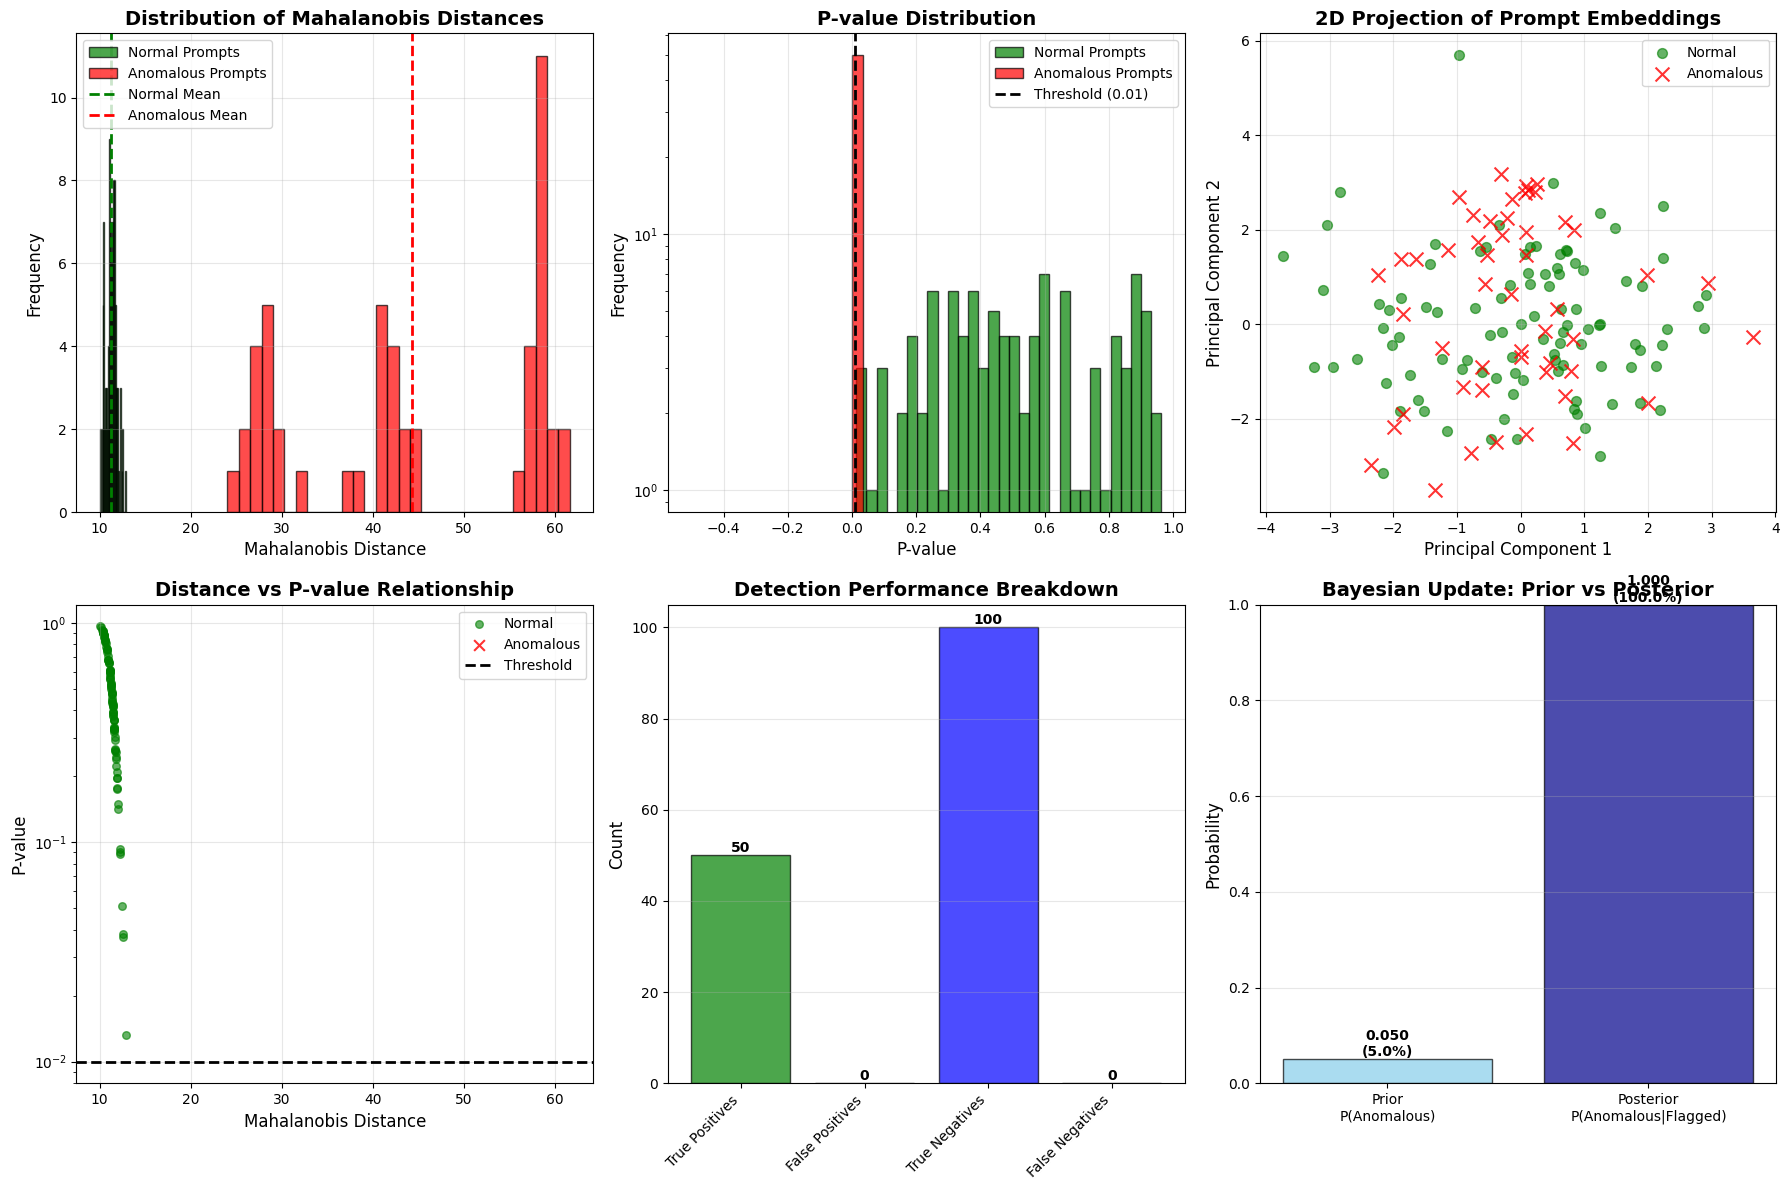

 Visualizations saved as 'anomaly_detection_analysis.png'



In [5]:
!pip install numpy matplotlib seaborn scipy scikit-learn -q

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance
import warnings
warnings.filterwarnings('ignore')


print("="*70)
#print("STEP : GENERATING SYNTHETIC PROMPT EMBEDDINGS")
print("="*70)

np.random.seed(42)

n_normal_prompts = 500
n_anomalous_prompts = 50
embedding_dim = 128

print(f"\nGenerating {n_normal_prompts} normal prompt embeddings...")
print(f"Embedding dimension: {embedding_dim}")

normal_mean = np.zeros(embedding_dim)
normal_cov = np.eye(embedding_dim) * 0.5
normal_embeddings = np.random.multivariate_normal(normal_mean, normal_cov, n_normal_prompts)

print(f" Normal embeddings shape: {normal_embeddings.shape}")

print(f"\nGenerating {n_anomalous_prompts} anomalous prompt embeddings...")

anomalous_embeddings = []
for i in range(n_anomalous_prompts):
    if i < 20:

        anom = np.random.multivariate_normal(normal_mean + 3, normal_cov, 1)
    elif i < 35:

        anom = np.random.multivariate_normal(normal_mean, normal_cov * 5, 1)
    else:

        anom = np.random.multivariate_normal(normal_mean - 2, normal_cov * 2, 1)
    anomalous_embeddings.append(anom[0])

anomalous_embeddings = np.array(anomalous_embeddings)
print(f" Anomalous embeddings shape: {anomalous_embeddings.shape}\n")

print("="*70)
print("TASK 1: LINEAR ALGEBRA ANALYSIS")
print("="*70)

print("\n1.1 Computing Covariance Matrix of Normal Prompts...")
print("-" * 60)

cov_matrix = np.cov(normal_embeddings.T)
print(f"Covariance Matrix Shape: {cov_matrix.shape}")
print(f"Covariance Matrix is symmetric: {np.allclose(cov_matrix, cov_matrix.T)}")

mean_normal = np.mean(normal_embeddings, axis=0)
print(f"Mean vector shape: {mean_normal.shape}")

print("\n1.2 Computing Mahalanobis Distances...")
print("-" * 60)


try:
    cov_inv = np.linalg.inv(cov_matrix)
    print(" Covariance matrix inverted successfully")
except:

    cov_inv = np.linalg.pinv(cov_matrix)
    print(" Using pseudo-inverse (matrix was near-singular)")

def compute_mahalanobis(point, mean, cov_inv):
    """
    Mahalanobis distance measures how many standard deviations away
    a point is from the mean, accounting for correlations.

    Formula: D = sqrt((x - μ)ᵀ Σ⁻¹ (x - μ))
    """
    diff = point - mean
    distance = np.sqrt(diff.T @ cov_inv @ diff)
    return distance

print("\nComputing distances for normal prompts...")
normal_distances = []
for prompt in normal_embeddings[:100]:
    dist = compute_mahalanobis(prompt, mean_normal, cov_inv)
    normal_distances.append(dist)

normal_distances = np.array(normal_distances)
print(f"Normal prompts - Mean distance: {np.mean(normal_distances):.4f}")
print(f"Normal prompts - Std distance: {np.std(normal_distances):.4f}")

print("\nComputing distances for anomalous prompts...")
anomalous_distances = []
for prompt in anomalous_embeddings:
    dist = compute_mahalanobis(prompt, mean_normal, cov_inv)
    anomalous_distances.append(dist)

anomalous_distances = np.array(anomalous_distances)
print(f"Anomalous prompts - Mean distance: {np.mean(anomalous_distances):.4f}")
print(f"Anomalous prompts - Std distance: {np.std(anomalous_distances):.4f}")

print("\n INSIGHT: Anomalous prompts have MUCH LARGER distances!")
print(f"   Ratio: {np.mean(anomalous_distances)/np.mean(normal_distances):.2f}x larger\n")

print("="*70)
print("TASK 2: PROBABILITY ANALYSIS")
print("="*70)

print("\n2.1 Chi-Square Distribution Assumption")
print("-" * 60)
print("Mahalanobis distances squared follow a chi-square distribution")
print(f"Degrees of freedom: {embedding_dim}")

normal_distances_sq = normal_distances ** 2
anomalous_distances_sq = anomalous_distances ** 2

print("\n2.2 Computing P-values...")
print("-" * 60)

normal_pvalues = 1 - stats.chi2.cdf(normal_distances_sq, df=embedding_dim)
anomalous_pvalues = 1 - stats.chi2.cdf(anomalous_distances_sq, df=embedding_dim)

print(f"Normal prompts - Mean p-value: {np.mean(normal_pvalues):.6f}")
print(f"Anomalous prompts - Mean p-value: {np.mean(anomalous_pvalues):.6e}")

threshold_pvalue = 0.01
print(f"\n2.3 Detection Threshold: p-value < {threshold_pvalue}")
print("-" * 60)

flagged_normal = np.sum(normal_pvalues < threshold_pvalue)
flagged_anomalous = np.sum(anomalous_pvalues < threshold_pvalue)

print(f"Normal prompts flagged: {flagged_normal}/{len(normal_pvalues)} ({flagged_normal/len(normal_pvalues)*100:.1f}%)")
print(f"Anomalous prompts flagged: {flagged_anomalous}/{len(anomalous_pvalues)} ({flagged_anomalous/len(anomalous_pvalues)*100:.1f}%)")

true_positive_rate = flagged_anomalous / len(anomalous_pvalues)
false_positive_rate = flagged_normal / len(normal_pvalues)

print(f"\n True Positive Rate (Detection Rate): {true_positive_rate*100:.1f}%")
print(f" False Positive Rate: {false_positive_rate*100:.1f}%\n")

print("="*70)
print("TASK 3: BAYESIAN ANALYSIS")
print("="*70)

print("\n3.1 Prior Information")
print("-" * 60)

prior_anomaly_rate = 0.05
prior_normal_rate = 1 - prior_anomaly_rate

print(f"Prior probability of anomalous prompt: {prior_anomaly_rate:.3f}")
print(f"Prior probability of normal prompt: {prior_normal_rate:.3f}")

sensitivity = true_positive_rate
specificity = 1 - false_positive_rate

print(f"\nDetection System Performance:")
print(f"  Sensitivity P(Flag|Anomalous): {sensitivity:.3f}")
print(f"  Specificity P(Not Flag|Normal): {specificity:.3f}")
print(f"  False Positive Rate P(Flag|Normal): {false_positive_rate:.3f}")

print("\n3.2 Applying Bayes' Theorem")
print("-" * 60)
print("Computing: P(Anomalous | Flagged)")
print("\nBayes Formula:")
print("P(A|F) = P(F|A) × P(A) / [P(F|A) × P(A) + P(F|N) × P(N)]")
print("Where:")
print("  A = Anomalous, N = Normal, F = Flagged")

p_flag_given_anomalous = sensitivity
p_flag_given_normal = false_positive_rate

numerator = p_flag_given_anomalous * prior_anomaly_rate
denominator = (p_flag_given_anomalous * prior_anomaly_rate +
               p_flag_given_normal * prior_normal_rate)

posterior_anomalous_given_flagged = numerator / denominator

print(f"\n RESULT:")
print(f"Posterior P(Anomalous|Flagged) = {posterior_anomalous_given_flagged:.4f}")
print(f"\nInterpretation: When a prompt is flagged, there is a")
print(f"{posterior_anomalous_given_flagged*100:.1f}% probability it is truly malicious!\n")

print("="*70)
print("TASK 4: VISUALIZATION")
print("="*70)
print("\nGenerating visualizations...\n")

fig = plt.figure(figsize=(18, 12))

ax1 = plt.subplot(2, 3, 1)
plt.hist(normal_distances, bins=30, alpha=0.7, label='Normal Prompts', color='green', edgecolor='black')
plt.hist(anomalous_distances, bins=30, alpha=0.7, label='Anomalous Prompts', color='red', edgecolor='black')
plt.axvline(np.mean(normal_distances), color='green', linestyle='--', linewidth=2, label='Normal Mean')
plt.axvline(np.mean(anomalous_distances), color='red', linestyle='--', linewidth=2, label='Anomalous Mean')
plt.xlabel('Mahalanobis Distance', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Mahalanobis Distances', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
plt.hist(normal_pvalues, bins=30, alpha=0.7, label='Normal Prompts', color='green', edgecolor='black')
plt.hist(anomalous_pvalues, bins=30, alpha=0.7, label='Anomalous Prompts', color='red', edgecolor='black')
plt.axvline(threshold_pvalue, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold_pvalue})')
plt.xlabel('P-value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('P-value Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.yscale('log')

ax3 = plt.subplot(2, 3, 3)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
normal_2d = pca.fit_transform(normal_embeddings[:100])
anomalous_2d = pca.transform(anomalous_embeddings)

plt.scatter(normal_2d[:, 0], normal_2d[:, 1], alpha=0.6, label='Normal', color='green', s=50)
plt.scatter(anomalous_2d[:, 0], anomalous_2d[:, 1], alpha=0.8, label='Anomalous', color='red', s=100, marker='x')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('2D Projection of Prompt Embeddings', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
plt.scatter(normal_distances, normal_pvalues, alpha=0.6, label='Normal', color='green', s=30)
plt.scatter(anomalous_distances, anomalous_pvalues, alpha=0.8, label='Anomalous', color='red', s=60, marker='x')
plt.axhline(threshold_pvalue, color='black', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel('Mahalanobis Distance', fontsize=12)
plt.ylabel('P-value', fontsize=12)
plt.title('Distance vs P-value Relationship', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.3)

ax5 = plt.subplot(2, 3, 5)
categories = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
values = [
    flagged_anomalous,
    flagged_normal,
    len(normal_pvalues) - flagged_normal,
    len(anomalous_pvalues) - flagged_anomalous
]
colors = ['green', 'orange', 'blue', 'red']
bars = plt.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Count', fontsize=12)
plt.title('Detection Performance Breakdown', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(value)}',
             ha='center', va='bottom', fontweight='bold')

ax6 = plt.subplot(2, 3, 6)
bayes_data = {
    'Prior\nP(Anomalous)': prior_anomaly_rate,
    'Posterior\nP(Anomalous|Flagged)': posterior_anomalous_given_flagged
}
bars = plt.bar(bayes_data.keys(), bayes_data.values(),
               color=['skyblue', 'darkblue'], alpha=0.7, edgecolor='black')
plt.ylabel('Probability', fontsize=12)
plt.title('Bayesian Update: Prior vs Posterior', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for bar, (key, value) in zip(bars, bayes_data.items()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}\n({value*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('anomaly_detection_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Visualizations saved as 'anomaly_detection_analysis.png'\n")

